## Reinforcement Learning

### Introduction to OpenAI Gym

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 44.6 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 23.0.1
    Uninstalling pip-23.0.1:
      Successfully uninstalled pip-23.0.1
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> [16 lines of output]
      Using setuptools (version 65.5.0).
      running bdist_wheel
      running build
      running build_py
      creating build
      creating build/lib.linux-x86_64-cpython-310
      creating build/lib.linux-x86_64-cpython-310/Box2D
      copying library/Box2D/__init__.py -> build/lib.linux-x86_64-cpython-310/Box2D
      copying library/Box2D/Box2D.py -> build/lib.linux-x86_64-cpython-310/Box2D
      creating build/lib.linux-x86_

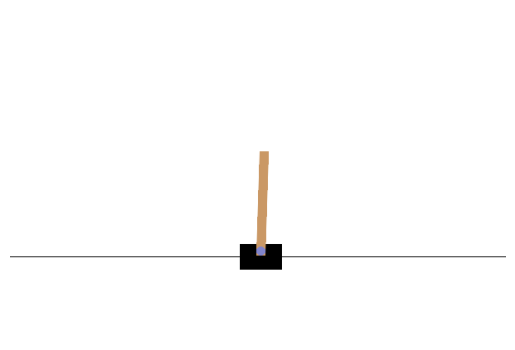

/root/venv/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
/root/venv/lib/python3.10/site-packages/gym/envs/classic_control/cartpole.py:177: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
  logger.warn(


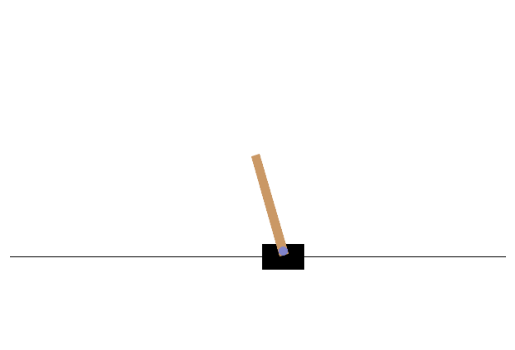

In [1]:
%pip install --upgrade pip
%pip install -q -U gym
%pip install -q -U gym[classic_control]
%pip install -q -U gym[box2d]
%pip install -q -U gym[atari]
%pip install -q -U gym[accept-rom-license]
import gym
import matplotlib.pyplot as plt

env = gym.make('CartPole-v1', render_mode='rgb_array')
obs, info = env.reset(seed=42)

img = env.render()

plt.imshow(img)
plt.axis("off")
plt.show()

action = 1
for a in range(10):
    env.step(action)
obs, reward, done, truncated, info = env.step(action)

img = env.render()

plt.imshow(img)
plt.axis("off")
plt.show()

In [22]:
%pip install --upgrade pip
%pip install -q -U gym
%pip install -q -U gym[classic_control]
%pip install -q -U gym[box2d]
%pip install -q -U gym[atari]
%pip install -q -U gym[accept-rom-license]
import gym
import matplotlib.pyplot as plt
import numpy as np

def basic_policy(obs):
    angle = obs[2]
    return 0 if angle < 0 else 1

env = gym.make('CartPole-v1', render_mode='rgb_array')

totals = []
for episode in range(500):
    episode_rewards = 0
    obs, info = env.reset(seed=episode)
    for step in range(200):
        action = basic_policy(obs)
        obs, reward, done, truncated, info = env.step(action)
        episode_rewards += reward
        if done:
            break
    totals.append(episode_rewards)

np.mean(totals), np.std(totals), min(totals), max(totals)

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> [16 lines of output]
      Using setuptools (version 65.5.0).
      running bdist_wheel
      running build
      running build_py
      creating build
      creating build/lib.linux-x86_64-cpython-310
      creating build/lib.linux-x86_64-cpython-310/Box2D
      copying library/Box2D/__init__.py -> build/lib.linux-x86_64-cpython-310/Box2D
      copying library/Box2D/Box2D.py -> build/lib.linux-x86_64-cpython-310/Box2D
      creating build/lib.linux-x86_64-cpython-310/Box2D/b2
      copying library/Box2D/b2/__init__.py -> build/lib.linux-x86_64-cpython-310/Box2D/b2
      running build_ext
      building 'Box2D._Box2D' extension
      swigging Box2D/Box2D.i to Box2D/Box2D_

(41.698, 8.389445512070509, 24.0, 63.0)

### Policy Gradients

In [1]:
%pip install --upgrade pip
%pip install -q -U gym
%pip install -q -U gym[classic_control]
%pip install -q -U gym[box2d]
%pip install -q -U gym[atari]
%pip install -q -U gym[accept-rom-license]
import gym
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

def play_one_step(env, obs, model, loss_fn):
    with tf.GradientTape() as tape:
        left_proba = model(obs[np.newaxis])
        action = (tf.random.uniform([1, 1]) > left_proba)
        y_target = tf.constant([[1.]]) - tf.cast(action, tf.float32)
        loss = tf.reduce_mean(loss_fn(y_target, left_proba))
    grads = tape.gradient(loss, model.trainable_variables)
    obs, reward, done, truncated, info = env.step(int(action))
    return obs, reward, done, truncated, grads

def play_multiple_episodes(env, n_episodes, n_max_steps, model, loss_fn):
    all_rewards = []
    all_grads = []
    for episode in range(n_episodes):
        current_rewards = []
        current_grads = []
        obs, info = env.reset()
        for step in range(n_max_steps):
            obs, reward, done, truncated, grads = play_one_step(env, obs, model, loss_fn)
            current_rewards.append(reward)
            current_grads.append(grads)
            if done or truncated:
                break
        all_rewards.append(current_rewards)
        all_grads.append(current_grads)
    return all_rewards, all_grads

def discount_rewards(rewards, discount_factor):
    discounted = np.array(rewards)
    for step in (range(len(rewards) - 2, -1, -1)):
        discounted[step] += discounted[step + 1] * discount_factor
    return discounted

def discount_and_normalize_rewards(all_rewards, discount_factor):
    all_discounted_rewards = [discount_rewards(rewards, discount_factor)
                              for rewards in all_rewards]
    flat_rewards = np.concatenate(all_discounted_rewards)
    reward_mean = flat_rewards.mean()
    reward_std = flat_rewards.std()
    return [(discounted_rewards - reward_mean) / reward_std
            for discounted_rewards in all_discounted_rewards]

n_iterations = 150
n_episodes_per_update = 10
n_max_steps = 200
discount_factor = 0.95
optimizer = tf.keras.optimizers.Nadam(learning_rate=0.01)
loss_fn = tf.keras.losses.binary_crossentropy
env = gym.make('CartPole-v1', render_mode='rgb_array')

model = tf.keras.Sequential([
    tf.keras.layers.Dense(5, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

for iteration in range(n_iterations):
    all_rewards, all_grads = play_multiple_episodes(
        env,
        n_episodes_per_update,
        n_max_steps,
        model, 
        loss_fn
    )
    all_final_rewards = discount_and_normalize_rewards(all_rewards, discount_factor)
    all_mean_grads = []
    for var_index in range(len(model.trainable_variables)):
        mean_grads = tf.reduce_mean(
            [final_reward * all_grads[episode_index][step][var_index]
                for episode_index, final_rewards in enumerate(all_final_rewards)
                    for step, final_reward in enumerate(final_rewards)
            ],
            axis=0
        )
        all_mean_grads.append(mean_grads)
    optimizer.apply_gradients(zip(all_mean_grads, model.trainable_variables))

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 39.8 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 23.0.1
    Uninstalling pip-23.0.1:
      Successfully uninstalled pip-23.0.1
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> [16 lines of output]
      Using setuptools (version 65.5.0).
      running bdist_wheel
      running build
      running build_py
      creating build
      creating build/lib.linux-x86_64-cpython-310
      creating build/lib.linux-x86_64-cpython-310/Box2D
      copying library/Box2D/__init__.py -> build/lib.linux-x86_64-cpython-310/Box2D
      copying library/Box2D/Box2D.py -> build/lib.linux-x86_64-cpython-310/Box2D
      creating build/lib.linux-x86_

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=968d3c27-50e7-4d42-bdd9-442f6904c1c2' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>